In [2]:
import rasterio
from rasterio.features import rasterize
import geopandas as gpd
import numpy as np
from pyproj import CRS
from shapely.geometry import box
from PIL import Image

In [2]:
# read shapefiles
greenhouse = gpd.read_file("spatial_data/final_polys/badajoz_greenhouse.shp")
solar = gpd.read_file("spatial_data/final_polys/badajoz_solar.shp")
#treecrop = gpd.read_file("spatial_data/final_polys/badajoz_treecrops.shp")
#urban = gpd.read_file("spatial_data/final_polys/badajoz_urban.shp")

In [24]:
solar.explore() # interactive visualization with geopandas

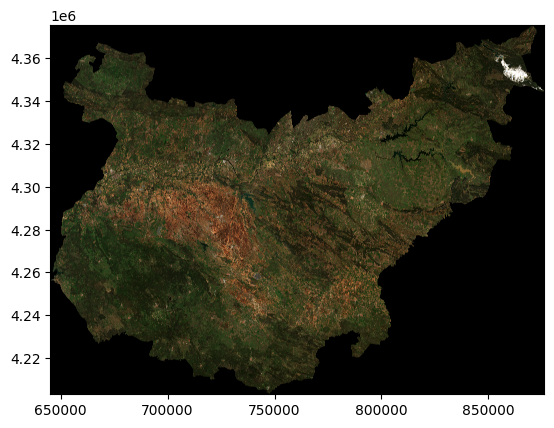

<Axes: >

In [4]:
# load raster
raster_path = 'spatial_data/merged_raster_preprocessed.tif'
raster = rasterio.open(raster_path)

from rasterio.plot import show
show(raster)

In [5]:
# get raster projection
raster_crs = CRS.from_wkt(raster.crs.to_wkt())

# reproyect polygons to raster projection
greenhouse = greenhouse.to_crs(raster_crs)
solar = solar.to_crs(raster_crs)
#treecrop = treecrop.to_crs(raster_crs)
#urban = urban.to_crs(raster_crs)

In [8]:
# again load raster base 
with rasterio.open('spatial_data/merged_raster_preprocessed.tif') as src:
    raster_meta = src.meta.copy() # shape
    raster_data = src.read(1) # data

In [9]:
# check if polygons overlap raster

# box geometry for raster
raster_bounds = box(*raster.bounds)

print(greenhouse.geometry.intersects(raster_bounds).any())
print(solar.geometry.intersects(raster_bounds).any())
#print(treecrop.geometry.intersects(raster_bounds).any())
#print(urban.geometry.intersects(raster_bounds).any())

True
True


In [10]:
# function to rasterize geodataframe with specific value
def rasterize_gdf(gdf, value, shape, transform):
    shapes = ((geom, value) for geom in gdf.geometry)
    return rasterize(shapes, out_shape=shape, transform=transform, fill=0)

In [11]:
# rasterize each class
greenhouse_raster = rasterize_gdf(greenhouse, 1, raster_data.shape, raster_meta['transform'])
solar_raster = rasterize_gdf(solar, 2, raster_data.shape, raster_meta['transform'])
#treecrop_raster = rasterize_gdf(treecrop, 3, raster_data.shape, raster_meta['transform'])
#urban_raster = rasterize_gdf(urban, 4, raster_data.shape, raster_meta['transform'])

In [12]:
# combine rasters (with priority, first one overlaps second, second overlaps third, and so on)
combined_raster = np.where(solar_raster > 0, solar_raster, 0)
combined_raster = np.where(greenhouse_raster > 0, greenhouse_raster, combined_raster)
#combined_raster = np.where(treecrop_raster > 0, treecrop_raster, combined_raster)
#combined_raster = np.where(urban_raster > 0, urban_raster, combined_raster)

In [13]:
# assign 5 to the pixels that don't lay within any polygon
#combined_raster = np.where(combined_raster == 0, 5, combined_raster)

# assign 3 to the pixels that don't lay within any polygon
combined_raster = np.where(combined_raster == 0, 3, combined_raster)

In [14]:
# assign 0 to pixels in which the original raster was 0 (outside Badajoz borders)
masked_combined_raster = np.where(raster_data == 0, 0, combined_raster)

In [15]:
# save new raster basing on original raster
#raster_meta.update(dtype=rasterio.int32, count=1)
#with rasterio.open('spatial_data/badajoz_multiclass_mask.tif', 'w', **raster_meta) as dst:
#    dst.write(masked_combined_raster, 1)
    
    # save new raster basing on original raster
raster_meta.update(dtype=rasterio.int32, count=1)
with rasterio.open('spatial_data/badajoz_multiclass_mask.tif', 'w', **raster_meta) as dst:
    dst.write(masked_combined_raster, 1)

In [4]:
# reload with pillow, convert to png, save

Image.MAX_IMAGE_PIXELS = None # turn off protection against decompression bomb

rgb_image = Image.open('spatial_data/merged_raster_preprocessed.tif')
mask_image = Image.open('spatial_data/badajoz_multiclass_mask.tif')

rgb_png = rgb_image.convert('RGB')
# for mask it's not necessary since it's single-band

rgb_png.save('spatial_data/merged_raster_preprocessed.png', 'PNG')
mask_image.save('spatial_data/badajoz_multiclass_mask.png', 'PNG')


In [5]:
mask_np = np.array(mask_image)
np.unique(mask_np)

# values are ok

array([0, 1, 2, 3])